In [1]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import time
import numpy as np

In [2]:
def orthogonal_tetrahedra_formfactor(V1, V2, V3, qx, qy, qz, DENSITY):
    """
    Calculate the form factor (scattering amplitude) of orthogonal tetrahedra.
    https://doi.org/10.1107/S160057672201130X
    
    Parameters:
    V1, V2, V3 (numpy.ndarray): Vertices of the tetrahedron.
    qx, qy, qz (numpy.ndarray): Components of the wave vector.
    DENSITY (float): Density of the material.
    
    Returns:
    numpy.ndarray: Scattering amplitude.
    
    Originaal MATLAB code description:
    % Calculate the form factor (scattering amplitude) of orthogonal tetrahedra.
    % Code written by Tianjuan Yang.
    """
    T = np.array([V1, V2, V3]).T
    Q1 = qx * V1[0] + qy * V1[1] + qz * V1[2]
    Q2 = qx * V2[0] + qy * V2[1] + qz * V2[2]
    Q3 = qx * V3[0] + qy * V3[1] + qz * V3[2]
    det_T = np.linalg.det(T)
    
    scattering_amplitude = DENSITY * det_T * (1j * np.exp(1j * Q3) / (Q3 * (Q3 - Q2) * (Q3 - Q1)) +
                                              1j * np.exp(1j * Q2) / (Q2 * (Q2 - Q1) * (Q2 - Q3)) +
                                              1j * np.exp(1j * Q1) / (Q1 * (Q1 - Q2) * (Q1 - Q3)) -
                                              1j / (Q1 * Q2 * Q3))
    
    # Calculation at singularities
    row2 = np.where((np.abs(Q1) <= 1e-9) & (np.abs(Q2) >= 1e-9) & (np.abs(Q3) >= 1e-9) & (np.abs(Q2 - Q3) >= 1e-9))
    scattering_amplitude[row2] = DENSITY * det_T * (1j * np.exp(1j * Q2[row2]) / (Q2[row2]**2 * (Q2[row2] - Q3[row2])) +
                                                    1j * np.exp(1j * Q3[row2]) / (Q3[row2]**2 * (Q3[row2] - Q2[row2])) +
                                                    1j * (Q2[row2] + Q3[row2] + 1j * Q2[row2] * Q3[row2]) / (Q2[row2]**2 * Q3[row2]**2))
    
    row3 = np.where((np.abs(Q2) <= 1e-9) & (np.abs(Q1) >= 1e-9) & (np.abs(Q3) >= 1e-9) & (np.abs(Q1 - Q3) >= 1e-9))
    scattering_amplitude[row3] = DENSITY * det_T * (1j * np.exp(1j * Q1[row3]) / (Q1[row3]**2 * (Q1[row3] - Q3[row3])) +
                                                    1j * np.exp(1j * Q3[row3]) / (Q3[row3]**2 * (Q3[row3] - Q1[row3])) +
                                                    1j * (Q1[row3] + Q3[row3] + 1j * Q1[row3] * Q3[row3]) / (Q1[row3]**2 * Q3[row3]**2))
    
    row4 = np.where((np.abs(Q3) <= 1e-9) & (np.abs(Q1) >= 1e-9) & (np.abs(Q2) >= 1e-9) & (np.abs(Q1 - Q2) >= 1e-9))
    scattering_amplitude[row4] = DENSITY * det_T * (1j * np.exp(1j * Q1[row4]) / (Q1[row4]**2 * (Q1[row4] - Q2[row4])) +
                                                    1j * np.exp(1j * Q2[row4]) / (Q2[row4]**2 * (Q2[row4] - Q1[row4])) +
                                                    1j * (Q1[row4] + Q2[row4] + 1j * Q1[row4] * Q2[row4]) / (Q1[row4]**2 * Q2[row4]**2))
    
    row5 = np.where((np.abs(Q1 - Q3) < 1e-9) & (np.abs(Q1) >= 1e-9) & (np.abs(Q1 - Q2) >= 1e-9) & (np.abs(Q3) >= 1e-9))
    scattering_amplitude[row5] = DENSITY * det_T * (1j * np.exp(1j * Q2[row5]) / (Q2[row5] * (Q2[row5] - Q1[row5])**2) +
                                                    np.exp(1j * Q1[row5]) * (1j * Q2[row5] - 2j * Q1[row5] - Q1[row5]**2 + Q1[row5] * Q2[row5]) / ((Q2[row5] - Q1[row5])**2 * Q1[row5]**2) -
                                                    1j / (Q1[row5]**2 * Q2[row5]))
    
    row6 = np.where((np.abs(Q1 - Q2) < 1e-9) & (np.abs(Q1) >= 1e-9) & (np.abs(Q2 - Q3) >= 1e-9) & (np.abs(Q2) >= 1e-9))
    scattering_amplitude[row6] = DENSITY * det_T * (1j * np.exp(1j * Q3[row6]) / (Q3[row6] * (Q3[row6] - Q1[row6])**2) +
                                                    np.exp(1j * Q1[row6]) * (1j * Q3[row6] - 2j * Q1[row6] - Q1[row6]**2 + Q1[row6] * Q3[row6]) / ((Q3[row6] - Q1[row6])**2 * Q1[row6]**2) -
                                                    1j / (Q1[row6]**2 * Q3[row6]))
    
    row7 = np.where((np.abs(Q2 - Q3) < 1e-9) & (np.abs(Q2) >= 1e-9) & (np.abs(Q1 - Q3) >= 1e-9) & (np.abs(Q3) >= 1e-9))
    scattering_amplitude[row7] = DENSITY * det_T * (1j * np.exp(1j * Q1[row7]) / (Q1[row7] * (Q1[row7] - Q2[row7])**2) +
                                                    np.exp(1j * Q2[row7]) * (1j * Q1[row7] - 2j * Q2[row7] - Q2[row7]**2 + Q2[row7] * Q1[row7]) / ((Q1[row7] - Q2[row7])**2 * Q2[row7]**2) -
                                                    1j / (Q2[row7]**2 * Q1[row7]))
    
    row8 = np.where((np.abs(Q1 - Q2) <= 1e-5) & (np.abs(Q1 - Q3) <= 1e-5) & (np.abs(Q2 - Q3) <= 1e-5) & (np.abs(Q1) >= 1e-9) & (np.abs(Q2) >= 1e-9) & (np.abs(Q3) >= 1e-9))
    scattering_amplitude[row8] = DENSITY * det_T * (np.exp(1j * Q1[row8]) * (2j + 2 * Q1[row8] - 1j * Q1[row8]**2) / (2 * Q1[row8]**3) - 1j / Q1[row8]**3)
    
    row9 = np.where(Q1**2 + Q2**2 + Q3**2 < 1e-3)
    scattering_amplitude[row9] = DENSITY * det_T / 6 + 1j * det_T * (Q1[row9] + Q2[row9] + Q3[row9])
    
    return scattering_amplitude

def scattering_function_tetrahedron(verts, tetrahedra, q_grid):
    """
    Evaluate the scattering function of the whole mesh over a grid of wave vectors for tetrahedra.
    
    Parameters:
    vertices (numpy.ndarray): Array of shape (n, 3) containing the vertices of the mesh.
    tetrahedra (numpy.ndarray): Array of shape (m, 4) containing the indices of the vertices forming each tetrahedron.
    q_grid (list): List of 3 numpy arrays representing the grid of wave vectors.
    
    Returns:
    numpy.ndarray: The scattering function values over the grid.
    """
    print("Flattening q_grid...")
    start_time = time.time()
    q_grid_flat = np.array([q_grid[0].flatten(), q_grid[1].flatten(), q_grid[2].flatten()])
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating tetrahedron volumes...")
    start_time = time.time()
    r0 = verts[tetrahedra[:, 0]]
    r1 = verts[tetrahedra[:, 1]]
    r2 = verts[tetrahedra[:, 2]]
    r3 = verts[tetrahedra[:, 3]]
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating orthogonal tetrahedra form factor...")
    start_time = time.time()
    V1 = r1 - r0
    V2 = r2 - r0
    V3 = r3 - r0
    qx, qy, qz = q_grid_flat
    
    form_factors = np.zeros((tetrahedra.shape[0], q_grid_flat.shape[1]), dtype=complex)
    for i in range(tetrahedra.shape[0]):
        form_factors[i] = orthogonal_tetrahedra_formfactor(V1[i], V2[i], V3[i], qx, qy, qz, 1) * np.exp(1j * (qx * r0[i, 0] + qy * r0[i, 1] + qz * r0[i, 2]))
    print(f"Time taken: {time.time() - start_time} seconds")
    
    F_q = np.sum(form_factors, axis=0)
    
    print("Calculating scattering function I_q...")
    start_time = time.time()
    I_q = np.abs(F_q) ** 2
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Scattering function calculation complete.")
    return I_q

## Generate regular polynedron pillar

In [3]:
# We consider particles having the shape of a right prism of length L and a cross-section made of a regular polygon with n sides
def generate_prism(n, R, AR, center = (0, 0, 0)):
    """
    Generate vertices and faces for a right prism with a regular polygon base.
    
    Parameters:
    n (int): Number of sides of the regular polygon.
    R (float): Radius of circumradius circle of the regular polygon.
    AR (float): Aspect ratio of the prism.
    
    Returns:
    tuple: Tuple containing vertices and faces of the prism.
    """
    # Calculate the area of the base polygon
    r = R/2/np.pi 
    A = 0.5 * n * r**2 * np.sin(2*np.pi/n)
    
    # Calculate the R_ave of the base polygon
    R_ave = np.sqrt(A/np.pi)
    
    # Calculate the length of the prism
    L = AR * R_ave*2
    
    
    # Generate the vertices of the base polygon
    theta = np.linspace(0, 2 * np.pi, n, endpoint=False) + 1e-6
    x = np.cos(theta)*r
    y = np.sin(theta)*r
    z = np.zeros_like(x)
    print(r)
    
    # Vertices of the top and bottom faces
    vertices = np.vstack((np.column_stack((x, y, z)), np.column_stack((x, y, z + L))))
    
    # # Generate the faces
    # faces = []
    # for i in range(n):
    #     next_i = (i + 1) % n
    #     # Bottom face
    #     faces.append([i, next_i, next_i + n, i + n])
    #     # Top face
    #     faces.append([i, next_i, next_i + n, i + n])
    
    return vertices

23.8732414637843


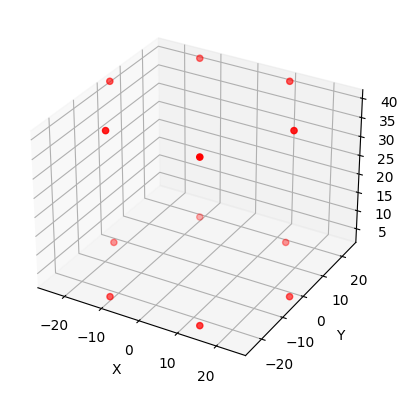

In [4]:
# Generate the vertices and faces of the prism
n = 6
R = 150
AR = 1
vertices = generate_prism(n, R, AR)
L = np.max(vertices[:, 2]) - np.min(vertices[:, 2])
# v_bottom = np.array([0, 0, 0])
# v_top = np.array([0, 0, L])
# vertices = np.vstack((vertices, v_top, v_bottom))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, z coordinates of vertices
x = vertices[:, 0]
y = vertices[:, 1]
z = vertices[:, 2]

# Plot the vertices
ax.scatter(x, y, z, c='r', marker='o')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_aspect('equal')

plt.show()

23.8732414637843
0, 1
1, 2
2, 3
3, 4
4, 5
5, 0


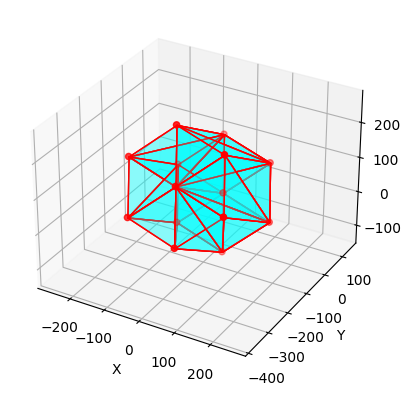

In [5]:
verts = generate_prism(n, R, AR)
L = np.max(vertices[:, 2]) - np.min(vertices[:, 2])
v_bottom = np.array([0, 0, 0])
v_top = np.array([0, 0, L])
verts = np.vstack((verts, v_bottom, v_top))*2*np.pi

# Rotate verts around z-axis
theta_z = np.pi/4
rotation_matrix_z = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
                              [np.sin(theta_z), np.cos(theta_z), 0],
                              [0, 0, 1]])
verts = verts @ rotation_matrix_z.T

# stretch_matrix = np.array([[2,0,0],[0,1,0],[0,0,1]])
# verts = verts @ stretch_matrix.T

# Rotate verts around x-axis
theta_x = np.pi/3
rotation_matrix_x = np.array([[1, 0, 0],
                              [0, np.cos(theta_x), -np.sin(theta_x)],
                              [0, np.sin(theta_x), np.cos(theta_x)]])
verts = verts @ rotation_matrix_x.T

# Rotate verts around y-axis
theta_y = 2e-7
rotation_matrix_y = np.array([[np.cos(theta_y), 0, np.sin(theta_y)],
                              [0, 1, 0],
                              [-np.sin(theta_y), 0, np.cos(theta_y)]])
verts = verts @ rotation_matrix_y.T


# generate the vertices of the tertrahedra
tetrahedra = []
for i in range(n):
    next_i = (i + 1) % n
    print(f"{i}, {next_i}")
    tri_prism = [2*n, i, next_i, 2*n+1, i+n, next_i+n]
    # tri_prism = [0,1,2,3,4,5]
    tetrahedra.append([tri_prism[0], tri_prism[1], tri_prism[2], tri_prism[3]])
    tetrahedra.append([tri_prism[1], tri_prism[3], tri_prism[4], tri_prism[5]])
    tetrahedra.append([tri_prism[1], tri_prism[2], tri_prism[3], tri_prism[5]])
    
tetrahedra = np.array(tetrahedra)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, tetra in enumerate(tetrahedra):
    color = 'cyan'
    for face in [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]:
        verts_face = verts[tetra[face]]
        ax.add_collection3d(Poly3DCollection([verts_face], facecolors=color, linewidths=1, edgecolors='r', alpha=.25))

# Extract x, y, z coordinates of vertices
x = verts[:, 0]
y = verts[:, 1]
z = verts[:, 2]

# Plot the vertices
ax.scatter(x, y, z, c='r', marker='o')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_aspect('equal')

plt.show()

In [6]:
qx = np.linspace(-1, 1, 100)*0.1
qy = np.linspace(-1, 1, 100)*0.1
qz = 0

q_grid = np.meshgrid(qx, qy, qz)
# q_grid_flat = np.array([q_grid[0].flatten(), q_grid[1].flatten(), q_grid[2].flatten()])
I_q_grid_flat = scattering_function_tetrahedron(verts, tetrahedra, q_grid)
I_q = I_q_grid_flat.reshape(q_grid[0].shape)

Flattening q_grid...
Time taken: 0.00017070770263671875 seconds
Calculating tetrahedron volumes...
Time taken: 3.0279159545898438e-05 seconds
Calculating orthogonal tetrahedra form factor...
Time taken: 0.04076671600341797 seconds
Calculating scattering function I_q...
Time taken: 2.86102294921875e-05 seconds
Scattering function calculation complete.


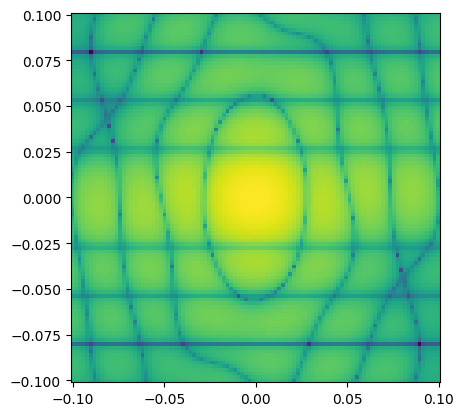

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

# pcolor plot of the scattering function
qx_plot = q_grid[0][:,:, 0]
qy_plot = q_grid[1][:,:, 0]
I_q_plot = I_q[:,:, 0]
ax.pcolor(qx_plot, qy_plot, np.log(I_q_plot), cmap='viridis')

ax.set_aspect('equal')

## for different polygons

In [8]:
def generate_tetrahedra(n, R, AR):
    verts = generate_prism(n, R, AR)
    L = np.max(verts[:, 2]) - np.min(verts[:, 2])
    v_bottom = np.array([0, 0, 0])
    v_top = np.array([0, 0, L])
    verts = np.vstack((verts, v_bottom, v_top)) * 2 * np.pi

    # generate the vertices of the tetrahedra
    tetrahedra = []
    for i in range(n):
        next_i = (i + 1) % n
        tri_prism = [2 * n, i, next_i, 2 * n + 1, i + n, next_i + n]
        tetrahedra.append([tri_prism[0], tri_prism[1], tri_prism[2], tri_prism[3]])
        tetrahedra.append([tri_prism[1], tri_prism[3], tri_prism[4], tri_prism[5]])
        tetrahedra.append([tri_prism[1], tri_prism[2], tri_prism[3], tri_prism[5]])

    tetrahedra = np.array(tetrahedra)
    return verts, tetrahedra

23.8732414637843
23.8732414637843
Flattening q_grid...
Time taken: 0.004203081130981445 seconds
Calculating tetrahedron volumes...
Time taken: 2.288818359375e-05 seconds
Calculating orthogonal tetrahedra form factor...


/tmp/ipykernel_444825/1420136849.py:24: RuntimeWarning: divide by zero encountered in divide
  scattering_amplitude = DENSITY * det_T * (1j * np.exp(1j * Q3) / (Q3 * (Q3 - Q2) * (Q3 - Q1)) +
/tmp/ipykernel_444825/1420136849.py:24: RuntimeWarning: invalid value encountered in divide
  scattering_amplitude = DENSITY * det_T * (1j * np.exp(1j * Q3) / (Q3 * (Q3 - Q2) * (Q3 - Q1)) +
/tmp/ipykernel_444825/1420136849.py:27: RuntimeWarning: divide by zero encountered in divide
  1j / (Q1 * Q2 * Q3))
/tmp/ipykernel_444825/1420136849.py:27: RuntimeWarning: invalid value encountered in divide
  1j / (Q1 * Q2 * Q3))
/tmp/ipykernel_444825/1420136849.py:24: RuntimeWarning: invalid value encountered in subtract
  scattering_amplitude = DENSITY * det_T * (1j * np.exp(1j * Q3) / (Q3 * (Q3 - Q2) * (Q3 - Q1)) +
/tmp/ipykernel_444825/1420136849.py:25: RuntimeWarning: divide by zero encountered in divide
  1j * np.exp(1j * Q2) / (Q2 * (Q2 - Q1) * (Q2 - Q3)) +
/tmp/ipykernel_444825/1420136849.py:25: Runtime

Time taken: 1.383411169052124 seconds
Calculating scattering function I_q...
Time taken: 0.0007536411285400391 seconds
Scattering function calculation complete.


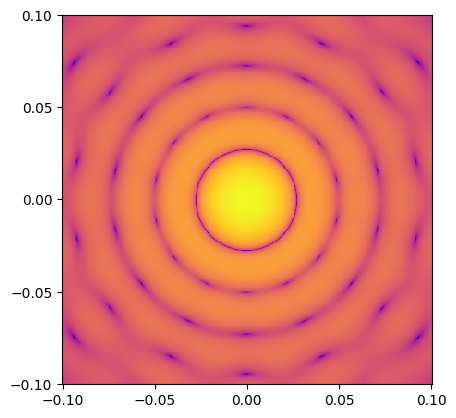

In [9]:
qx = np.linspace(-1, 1, 400)*0.1
qy = np.linspace(-1, 1, 400)*0.1
qz = 0

q_grid = np.meshgrid(qx, qy, qz)

n_list = [7]
verts, tetrahedra = generate_tetrahedra(4, 150, 3)
for n in n_list:
    verts, tetrahedra = generate_tetrahedra(n, R, AR)
    I_q_grid_flat = scattering_function_tetrahedron(verts, tetrahedra, q_grid)
    I_q = I_q_grid_flat.reshape(q_grid[0].shape)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # pcolor plot of the scattering function
    qx_plot = q_grid[0][:,:, 0]
    qy_plot = q_grid[1][:,:, 0]
    I_q_plot = I_q[:,:, 0]
    ax.pcolor(qx_plot, qy_plot, np.log(I_q_plot), cmap='plasma')
    ax.set_xticks(np.linspace(-0.1, 0.1, 5))
    ax.set_yticks(np.linspace(-0.1, 0.1, 5))
    ax.set_aspect('equal')

## test concave shapes

150
3
23.8732414637843
62.50095757382058
0, 1
1, 2
2, 3
3, 4
4, 0


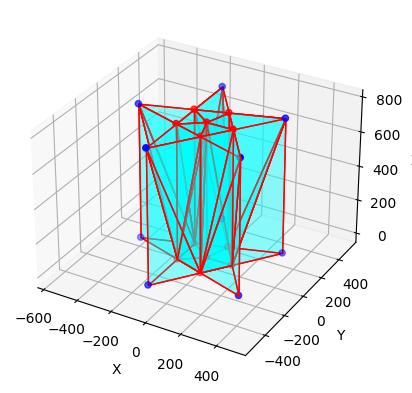

In [10]:
## Center polygon
n = 5
R = 150
AR = 3

print(R)
print(AR)
vertices_poly = generate_prism(n, R, AR)
L = np.max(vertices_poly[:, 2]) - np.min(vertices_poly[:, 2])
v_bottom = np.array([0, 0, 0])
v_top = np.array([0, 0, L])
vertices_poly = np.vstack((vertices_poly, v_bottom, v_top))*2*np.pi

tips_extend = np.tan(2*np.pi/n)*np.sin(np.pi/n) + np.cos(np.pi/n)
vertices_tips = generate_prism(n, R*tips_extend, AR/tips_extend)
# Rotate verts around z-axis
theta_z = np.pi/n
rotation_matrix_z = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
                              [np.sin(theta_z), np.cos(theta_z), 0],
                              [0, 0, 1]])
vertices_tips = vertices_tips @ rotation_matrix_z.T

vertices_tips = vertices_tips*2*np.pi

verts = np.vstack((vertices_poly, vertices_tips))

tetrahedra = []
for i in range(n):
    next_i = (i + 1) % n
    print(f"{i}, {next_i}")
    tri_prism = [2*n, i, next_i, 2*n+1, i+n, next_i+n]
    # tri_prism = [0,1,2,3,4,5]
    tetrahedra.append([tri_prism[0], tri_prism[1], tri_prism[2], tri_prism[3]])
    tetrahedra.append([tri_prism[1], tri_prism[3], tri_prism[4], tri_prism[5]])
    tetrahedra.append([tri_prism[1], tri_prism[2], tri_prism[3], tri_prism[5]])
    
    tri_prism_tips = [2*n+i+2, i, next_i, 3*n+i+2, i+n, next_i+n]
    tetrahedra.append([tri_prism_tips[0], tri_prism_tips[1], tri_prism_tips[3], tri_prism_tips[2]])
    tetrahedra.append([tri_prism_tips[1], tri_prism_tips[3], tri_prism_tips[5], tri_prism_tips[4]])
    tetrahedra.append([tri_prism_tips[1], tri_prism_tips[2], tri_prism_tips[5], tri_prism_tips[3]])
    
tetrahedra = np.array(tetrahedra)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, z coordinates of vertices
x = vertices_poly[:, 0]
y = vertices_poly[:, 1]
z = vertices_poly[:, 2]
# Plot the vertices
ax.scatter(x, y, z, c='r', marker='o',zorder=100)

# Extract x, y, z coordinates of vertices
xt = vertices_tips[:, 0]
yt = vertices_tips[:, 1]
zt = vertices_tips[:, 2]
# Plot the vertices
ax.scatter(xt, yt, zt, c='b', marker='o',zorder=100)

# plot the tetrahedra
for i, tetra in enumerate(tetrahedra):
    color = 'cyan'
    for face in [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]:
        verts_face = verts[tetra[face]]
        ax.add_collection3d(Poly3DCollection([verts_face], facecolors=color, linewidths=1, edgecolors='r', alpha=.25))

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_aspect('equal')

plt.show()

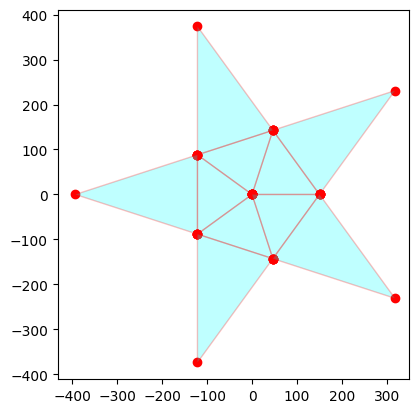

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(n):
    tetra_inner = tetrahedra[i*6]
    verts_inner = verts[tetra_inner]
    ax.scatter(verts_inner[:, 0], verts_inner[:, 1], c='r', marker='o')
    triangle = plt.Polygon(verts_inner[[0, 1, 2], :2], facecolor='cyan', edgecolor='r', alpha=0.25)
    ax.add_patch(triangle)
    
    tetra_outer = tetrahedra[i*6+3+1]
    verts_outer = verts[tetra_outer]
    ax.scatter(verts_outer[:, 0], verts_outer[:, 1], c='r', marker='o')
    triangle = plt.Polygon(verts_outer[[0, 1, 2], :2], facecolor='cyan', edgecolor='r', alpha=0.25)
    ax.add_patch(triangle)

ax.set_xlim(np.min(verts[:, 0])*1.1, np.max(verts[:, 0])*1.1)
ax.set_ylim(np.min(verts[:, 1])*1.1, np.max(verts[:, 1])*1.1)
ax.set_aspect('equal')

plt.show()

In [12]:
qx = np.linspace(-1, 1, 500)*0.1
qy = np.linspace(-1, 1, 500)*0.1
qz = 0

q_grid = np.meshgrid(qx, qy, qz)
# q_grid_flat = np.array([q_grid[0].flatten(), q_grid[1].flatten(), q_grid[2].flatten()])
I_q_grid_flat = scattering_function_tetrahedron(verts, tetrahedra, q_grid)
I_q = I_q_grid_flat.reshape(q_grid[0].shape)

Flattening q_grid...
Time taken: 0.004443645477294922 seconds
Calculating tetrahedron volumes...
Time taken: 4.363059997558594e-05 seconds
Calculating orthogonal tetrahedra form factor...


/tmp/ipykernel_444825/1420136849.py:24: RuntimeWarning: divide by zero encountered in divide
  scattering_amplitude = DENSITY * det_T * (1j * np.exp(1j * Q3) / (Q3 * (Q3 - Q2) * (Q3 - Q1)) +
/tmp/ipykernel_444825/1420136849.py:24: RuntimeWarning: invalid value encountered in divide
  scattering_amplitude = DENSITY * det_T * (1j * np.exp(1j * Q3) / (Q3 * (Q3 - Q2) * (Q3 - Q1)) +
/tmp/ipykernel_444825/1420136849.py:27: RuntimeWarning: divide by zero encountered in divide
  1j / (Q1 * Q2 * Q3))
/tmp/ipykernel_444825/1420136849.py:27: RuntimeWarning: invalid value encountered in divide
  1j / (Q1 * Q2 * Q3))
/tmp/ipykernel_444825/1420136849.py:24: RuntimeWarning: invalid value encountered in subtract
  scattering_amplitude = DENSITY * det_T * (1j * np.exp(1j * Q3) / (Q3 * (Q3 - Q2) * (Q3 - Q1)) +
/tmp/ipykernel_444825/1420136849.py:25: RuntimeWarning: divide by zero encountered in divide
  1j * np.exp(1j * Q2) / (Q2 * (Q2 - Q1) * (Q2 - Q3)) +
/tmp/ipykernel_444825/1420136849.py:25: Runtime

Time taken: 3.0497021675109863 seconds
Calculating scattering function I_q...
Time taken: 0.0005731582641601562 seconds
Scattering function calculation complete.


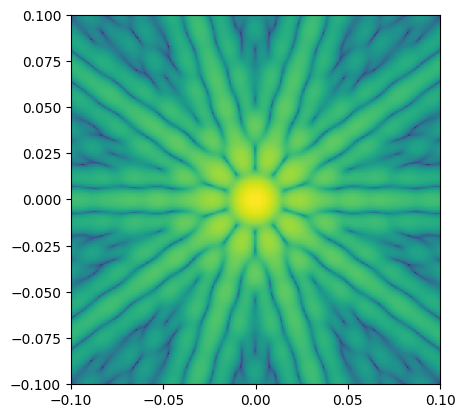

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

# pcolor plot of the scattering function
qx_plot = q_grid[0][:,:, 0]
qy_plot = q_grid[1][:,:, 0]
I_q_plot = I_q[:,:, 0]
ax.pcolor(qx_plot, qy_plot, np.log(I_q_plot), cmap='viridis')

ax.set_aspect('equal')

Processing for n = 6
23.8732414637843
41.34966715663439


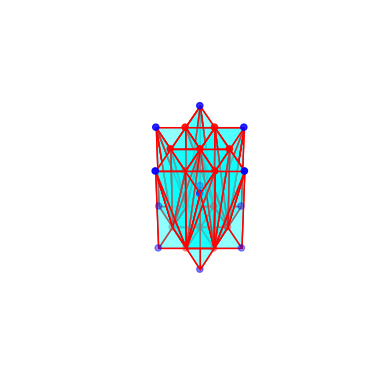

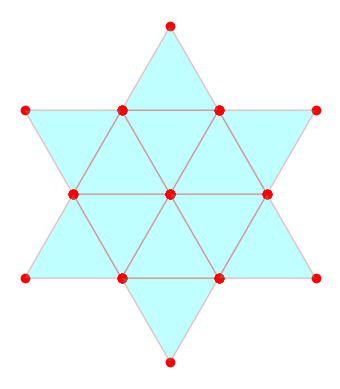

Flattening q_grid...
Time taken: 0.003390789031982422 seconds
Calculating tetrahedron volumes...
Time taken: 2.5033950805664062e-05 seconds
Calculating orthogonal tetrahedra form factor...


/tmp/ipykernel_444825/1420136849.py:24: RuntimeWarning: divide by zero encountered in divide
  scattering_amplitude = DENSITY * det_T * (1j * np.exp(1j * Q3) / (Q3 * (Q3 - Q2) * (Q3 - Q1)) +
/tmp/ipykernel_444825/1420136849.py:24: RuntimeWarning: invalid value encountered in divide
  scattering_amplitude = DENSITY * det_T * (1j * np.exp(1j * Q3) / (Q3 * (Q3 - Q2) * (Q3 - Q1)) +
/tmp/ipykernel_444825/1420136849.py:27: RuntimeWarning: divide by zero encountered in divide
  1j / (Q1 * Q2 * Q3))
/tmp/ipykernel_444825/1420136849.py:27: RuntimeWarning: invalid value encountered in divide
  1j / (Q1 * Q2 * Q3))
/tmp/ipykernel_444825/1420136849.py:24: RuntimeWarning: invalid value encountered in subtract
  scattering_amplitude = DENSITY * det_T * (1j * np.exp(1j * Q3) / (Q3 * (Q3 - Q2) * (Q3 - Q1)) +
/tmp/ipykernel_444825/1420136849.py:25: RuntimeWarning: divide by zero encountered in divide
  1j * np.exp(1j * Q2) / (Q2 * (Q2 - Q1) * (Q2 - Q3)) +
/tmp/ipykernel_444825/1420136849.py:25: Runtime

Time taken: 3.223773956298828 seconds
Calculating scattering function I_q...
Time taken: 0.0006003379821777344 seconds
Scattering function calculation complete.


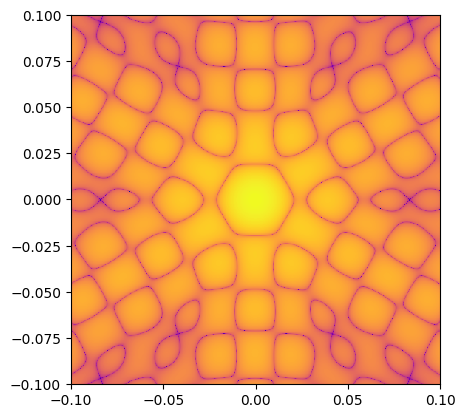

In [14]:
n_list = [6]
R = 150
AR = 3

for n in n_list:
    print(f"Processing for n = {n}")
    vertices_poly = generate_prism(n, R, AR)
    L = np.max(vertices_poly[:, 2]) - np.min(vertices_poly[:, 2])
    v_bottom = np.array([0, 0, 0])
    v_top = np.array([0, 0, L])
    vertices_poly = np.vstack((vertices_poly, v_bottom, v_top)) * 2 * np.pi

    tips_extend = np.tan(2 * np.pi / n) * np.sin(np.pi / n) + np.cos(np.pi / n)
    vertices_tips = generate_prism(n, R * tips_extend, AR / tips_extend)
    # Rotate verts around z-axis
    theta_z = np.pi / n
    rotation_matrix_z = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
                                  [np.sin(theta_z), np.cos(theta_z), 0],
                                  [0, 0, 1]])
    vertices_tips = vertices_tips @ rotation_matrix_z.T

    vertices_tips = vertices_tips * 2 * np.pi

    verts = np.vstack((vertices_poly, vertices_tips))

    tetrahedra = []
    for i in range(n):
        next_i = (i + 1) % n
        tri_prism = [2 * n, i, next_i, 2 * n + 1, i + n, next_i + n]
        tetrahedra.append([tri_prism[0], tri_prism[1], tri_prism[2], tri_prism[3]])
        tetrahedra.append([tri_prism[1], tri_prism[3], tri_prism[4], tri_prism[5]])
        tetrahedra.append([tri_prism[1], tri_prism[2], tri_prism[3], tri_prism[5]])

        tri_prism_tips = [2 * n + i + 2, i, next_i, 3 * n + i + 2, i + n, next_i + n]
        tetrahedra.append([tri_prism_tips[0], tri_prism_tips[1], tri_prism_tips[3], tri_prism_tips[2]])
        tetrahedra.append([tri_prism_tips[1], tri_prism_tips[3], tri_prism_tips[5], tri_prism_tips[4]])
        tetrahedra.append([tri_prism_tips[1], tri_prism_tips[2], tri_prism_tips[5], tri_prism_tips[3]])

    tetrahedra = np.array(tetrahedra)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract x, y, z coordinates of vertices
    x = vertices_poly[:, 0]
    y = vertices_poly[:, 1]
    z = vertices_poly[:, 2]
    # Plot the vertices
    ax.scatter(x, y, z, c='r', marker='o', zorder=100)

    # Extract x, y, z coordinates of vertices
    xt = vertices_tips[:, 0]
    yt = vertices_tips[:, 1]
    zt = vertices_tips[:, 2]
    # Plot the vertices
    ax.scatter(xt, yt, zt, c='b', marker='o', zorder=100)

    # plot the tetrahedra
    for i, tetra in enumerate(tetrahedra):
        color = 'cyan'
        for face in [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]:
            verts_face = verts[tetra[face]]
            ax.add_collection3d(Poly3DCollection([verts_face], facecolors=color, linewidths=1, edgecolors='r', alpha=.25))

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_aspect('equal')
    ax.view_init(elev=60., azim=30)
    ax.axis('off')

    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111)

    for i in range(n):
        tetra_inner = tetrahedra[i * 6]
        verts_inner = verts[tetra_inner]
        ax.scatter(verts_inner[:, 0], verts_inner[:, 1], c='r', marker='o')
        triangle = plt.Polygon(verts_inner[[0, 1, 2], :2], facecolor='cyan', edgecolor='r', alpha=0.25)
        ax.add_patch(triangle)

        tetra_outer = tetrahedra[i * 6 + 3 + 1]
        verts_outer = verts[tetra_outer]
        ax.scatter(verts_outer[:, 0], verts_outer[:, 1], c='r', marker='o')
        triangle = plt.Polygon(verts_outer[[0, 1, 2], :2], facecolor='cyan', edgecolor='r', alpha=0.25)
        ax.add_patch(triangle)

    ax.set_xlim(np.min(verts[:, 0]) * 1.1, np.max(verts[:, 0]) * 1.1)
    ax.set_ylim(np.min(verts[:, 1]) * 1.1, np.max(verts[:, 1]) * 1.1)
    ax.set_aspect('equal')
    ax.axis('off')

    plt.show()

    qx = np.linspace(-1, 1, 500) * 0.1
    qy = np.linspace(-1, 1, 500) * 0.1
    qz = 0

    q_grid = np.meshgrid(qx, qy, qz)
    I_q_grid_flat = scattering_function_tetrahedron(verts, tetrahedra, q_grid)
    I_q = I_q_grid_flat.reshape(q_grid[0].shape)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # pcolor plot of the scattering function
    qx_plot = q_grid[0][:, :, 0]
    qy_plot = q_grid[1][:, :, 0]
    I_q_plot = I_q[:, :, 0]
    ax.pcolor(qx_plot, qy_plot, np.log(I_q_plot), cmap='plasma')

    ax.set_aspect('equal')
    plt.show()
